In [1]:
import networkx as nx
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from collections import defaultdict
from functions import get_nodes_from_partition
from data.data3 import edges, nodes

 ### Our Data
 The graph that you'll be working with is a bipartite graph describing the American Revolution. There are two node partitions - ```'people'``` and ```'clubs'```, and edges denote a person being a member of a club.

In [2]:
G = nx.Graph()
G.add_edges_from(edges)
G.add_nodes_from(nodes)

### Computing projection
It's now time to compute the projection of a bipartite graph to the nodes on one of its partitions. This will help us gain practice with converting between a bipartite version of a graph and its unipartite projections. Tthe "projection" of a graph onto one of its partitions is the connectivity of the nodes in that partition conditioned on connections to nodes on the other partition. Made more concretely, you can think of the "connectivity of customers based on shared purchases".

In [3]:
# Prepare the nodelists needed for computing projections: people, clubs
people = [n for n in G.nodes() if G.node[n]['bipartite'] == 'people']
clubs = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'clubs']

# Compute the people and clubs projections: peopleG, clubsG
peopleG = nx.bipartite.projected_graph(G, people)
clubsG = nx.bipartite.projected_graph(G, clubs)

### Plot degree centrality on projection
Now, we're going to compare the degree centrality distributions for each of the following graphs: the original graph ```G```, the people graph projection ```peopleG```, and the clubs graph projection ```clubsG```. This will reinforce the difference in degree centrality score computation between bipartite and unipartite versions of degree centrality metrics.

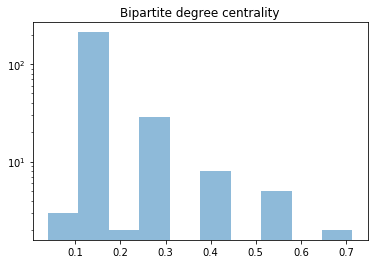

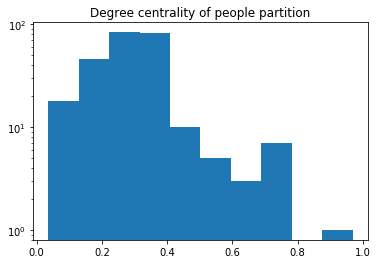

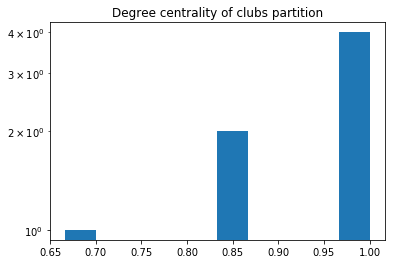

In [4]:
# Plot the degree centrality distribution of both node partitions from the original graph
plt.figure() 
original_dc = nx.bipartite.degree_centrality(G, people)  
plt.hist(list(original_dc.values()), alpha=0.5)
plt.yscale('log')
plt.title('Bipartite degree centrality')
plt.show()


# Plot the degree centrality distribution of the peopleG graph
plt.figure()
people_dc = nx.degree_centrality(peopleG)
plt.hist(list(people_dc.values()))
plt.yscale('log')
plt.title('Degree centrality of people partition')
plt.show()

# Plot the degree centrality distribution of the clubsG graph
plt.figure()
clubs_dc = nx.degree_centrality(clubsG)
plt.hist(list(clubs_dc.values()))
plt.yscale('log')
plt.title('Degree centrality of clubs partition')
plt.show()


### Compute adjacency matrix
Now, we'll get some practice using matrices and sparse matrix multiplication to compute projections! In this cell, we'll use the matrix multiplication operator ```@``` that was introduced in Python 3.5.

We'll continue working with the American Revolution graph. The two partitions of interest here are ```'people'``` and ```'clubs'```.

In [5]:
# Get the list of people and list of clubs from the graph: people_nodes, clubs_nodes
people_nodes = get_nodes_from_partition(G, 'people')
clubs_nodes = get_nodes_from_partition(G, 'clubs')

# Compute the biadjacency matrix: bi_matrix
bi_matrix = nx.bipartite.biadjacency_matrix(G, row_order=people_nodes, column_order=clubs_nodes)

# Compute the user-user projection: user_matrix
user_matrix = bi_matrix @ bi_matrix.T

print(user_matrix)

  (0, 208)	1
  (0, 207)	1
  (0, 206)	1
  (0, 205)	1
  (0, 204)	1
  (0, 203)	1
  (0, 202)	1
  (0, 201)	1
  (0, 200)	1
  (0, 199)	1
  (0, 198)	1
  (0, 197)	1
  (0, 196)	1
  (0, 195)	1
  (0, 194)	1
  (0, 193)	1
  (0, 192)	1
  (0, 191)	1
  (0, 190)	1
  (0, 189)	1
  (0, 188)	1
  (0, 187)	1
  (0, 186)	1
  (0, 185)	1
  (0, 184)	1
  :	:
  (252, 141)	1
  (252, 139)	1
  (252, 136)	1
  (252, 131)	1
  (252, 130)	1
  (252, 128)	1
  (252, 119)	1
  (252, 117)	1
  (252, 89)	1
  (252, 73)	1
  (252, 67)	1
  (252, 66)	1
  (252, 56)	1
  (252, 55)	1
  (252, 10)	1
  (253, 253)	1
  (253, 220)	1
  (253, 219)	1
  (253, 134)	1
  (253, 120)	1
  (253, 117)	1
  (253, 91)	1
  (253, 43)	1
  (253, 41)	1
  (253, 26)	1


### Find shared membership: Transposition 
We can observe that we lose the metadata from a graph when we go to a sparse matrix representation. We're now going to impute the metadata back so that we can learn more about shared membership.

Here, the ```np.where()``` function will prove useful. This is what it does: given an array, say, ```a = [1, 5, 9, 5]```, if you want to get the indices where the value is equal to ```5```, you can use ```idxs = np.where(a == 5)```. This gives you back an array in a tuple, ```(array([1, 3]),)```. To access those indices, you would want to index into the tuple as ```idxs[0]```.

In [6]:
import numpy as np 

# Find out the names of people who were members of the most number of clubs
diag = user_matrix.diagonal()             
indices = np.where(diag == diag.max())[0]
print('Number of clubs: {0}'.format(diag.max()))
print('People with the most number of memberships:')
for i in indices:
    print('- {0}'.format(people_nodes[i]))  

# Set the diagonal to zero and convert it to a coordinate matrix format
user_matrix.setdiag(0)
users_coo = user_matrix.tocoo()

# Find pairs of users who shared membership in the most number of clubs
indices = np.where(users_coo.data == users_coo.data.max())[0] 
print('People with most number of shared memberships:')
for idx in indices:
    print('- {0}, {1}'.format(people_nodes[users_coo.row[idx]], people_nodes[users_coo.col[idx]])) 


Number of clubs: 5
People with the most number of memberships:
- Revere.Paul
- Warren.Joseph
People with most number of shared memberships:
- Church.Benjamin, Warren.Joseph
- Church.Benjamin, Adams.Samuel
- Revere.Paul, Warren.Joseph
- Chase.Thomas, Bass.Henry
- Adams.Samuel, Warren.Joseph
- Adams.Samuel, Church.Benjamin
- Bass.Henry, Chase.Thomas
- Warren.Joseph, Adams.Samuel
- Warren.Joseph, Revere.Paul
- Warren.Joseph, Church.Benjamin
